In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

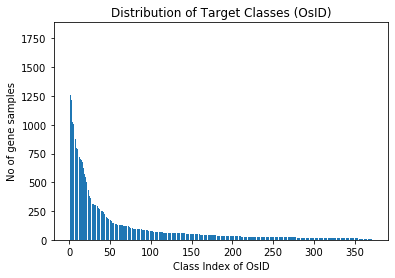

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=60, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

Number of input features: 1
Fold: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 13s 4ms/step - loss: 5.0019 - accuracy: 0.0436 - val_loss: 4.8821 - val_accuracy: 0.0750
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 4.4172 - accuracy: 0.0976 - val_loss: 4.2171 - val_accuracy: 0.1316
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9312 - accuracy: 0.1429 - val_loss: 3.8969 - val_accuracy: 0.1608
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6205 - accuracy: 0.1953 - val_loss: 3.6208 - val_accuracy: 0.2176
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3303 - accuracy: 0.2227 - val_loss: 3.3940 - val_accuracy: 0.1905
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0955 - accuracy: 0.2592 - val_loss: 3.1865 - val_accuracy: 0.3056
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9134 - accuracy: 0.2866 - val_loss: 3.0439 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 14s 4ms/step - loss: 5.0044 - accuracy: 0.0452 - val_loss: 4.8360 - val_accuracy: 0.0315
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 4.3443 - accuracy: 0.1081 - val_loss: 4.1524 - val_accuracy: 0.1745
Epoch 3/60
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8364 - accuracy: 0.1948 - val_loss: 3.6725 - val_accuracy: 0.2675
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1629 - accuracy: 0.3230 - val_loss: 2.9494 - val_accuracy: 0.3718
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4192 - accuracy: 0.4343 - val_loss: 2.4135 - val_accuracy: 0.4713
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9630 - accuracy: 0.5141 - val_loss: 2.1470 - val_accuracy: 0.5322
Epoch 7/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7116 - accuracy: 0.5602 - val_loss: 1.9734 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 11s 4ms/step - loss: 5.0279 - accuracy: 0.0411 - val_loss: 4.8371 - val_accuracy: 0.0550
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 4.0845 - accuracy: 0.1794 - val_loss: 3.6334 - val_accuracy: 0.2840
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1638 - accuracy: 0.3406 - val_loss: 3.0378 - val_accuracy: 0.3635
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6010 - accuracy: 0.4531 - val_loss: 2.6267 - val_accuracy: 0.4706
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1677 - accuracy: 0.5251 - val_loss: 2.2683 - val_accuracy: 0.5391
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8429 - accuracy: 0.5803 - val_loss: 2.0527 - val_accuracy: 0.5927
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6141 - accuracy: 0.6272 - val_loss: 1.8880 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 15s 5ms/step - loss: 5.0033 - accuracy: 0.0435 - val_loss: 4.8011 - val_accuracy: 0.0961
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2343 - accuracy: 0.1629 - val_loss: 3.8893 - val_accuracy: 0.2493
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3440 - accuracy: 0.3145 - val_loss: 3.1446 - val_accuracy: 0.3065
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5941 - accuracy: 0.4470 - val_loss: 2.5433 - val_accuracy: 0.4629
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0226 - accuracy: 0.5454 - val_loss: 2.1460 - val_accuracy: 0.5604
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6781 - accuracy: 0.6032 - val_loss: 1.8742 - val_accuracy: 0.5965
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4467 - accuracy: 0.6469 - val_loss: 1.7044 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 14s 4ms/step - loss: 4.6260 - accuracy: 0.0853 - val_loss: 3.9657 - val_accuracy: 0.1996
Epoch 2/60
1846/1846 [==============================] - 8s 4ms/step - loss: 3.3292 - accuracy: 0.3176 - val_loss: 3.0276 - val_accuracy: 0.4497
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4821 - accuracy: 0.4834 - val_loss: 2.4262 - val_accuracy: 0.5342
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9678 - accuracy: 0.5670 - val_loss: 2.0839 - val_accuracy: 0.5861
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6422 - accuracy: 0.6249 - val_loss: 1.8699 - val_accuracy: 0.6460
Epoch 6/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.4233 - accuracy: 0.6654 - val_loss: 1.7187 - val_accuracy: 0.6563
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2785 - accuracy: 0.6925 - val_loss: 1.6599 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 13s 4ms/step - loss: 4.4163 - accuracy: 0.0984 - val_loss: 3.9521 - val_accuracy: 0.1463
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4216 - accuracy: 0.2522 - val_loss: 3.0129 - val_accuracy: 0.4308
Epoch 3/60
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3567 - accuracy: 0.5081 - val_loss: 2.2153 - val_accuracy: 0.5668
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7380 - accuracy: 0.6099 - val_loss: 1.8302 - val_accuracy: 0.6306
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4230 - accuracy: 0.6581 - val_loss: 1.5824 - val_accuracy: 0.6647
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2423 - accuracy: 0.6939 - val_loss: 1.4120 - val_accuracy: 0.6788
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1181 - accuracy: 0.7174 - val_loss: 1.3235 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 13s 4ms/step - loss: 4.4498 - accuracy: 0.1080 - val_loss: 3.8643 - val_accuracy: 0.1837
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.2231 - accuracy: 0.3304 - val_loss: 2.9608 - val_accuracy: 0.4603
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4437 - accuracy: 0.4775 - val_loss: 2.4142 - val_accuracy: 0.5168
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9588 - accuracy: 0.5688 - val_loss: 2.0402 - val_accuracy: 0.5723
Epoch 5/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.6156 - accuracy: 0.6297 - val_loss: 1.7559 - val_accuracy: 0.6658
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3726 - accuracy: 0.6742 - val_loss: 1.6054 - val_accuracy: 0.6495
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2126 - accuracy: 0.7040 - val_loss: 1.5036 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 11s 4ms/step - loss: 4.5376 - accuracy: 0.0861 - val_loss: 4.0097 - val_accuracy: 0.1325
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4684 - accuracy: 0.2400 - val_loss: 3.2051 - val_accuracy: 0.3545
Epoch 3/60
1846/1846 [==============================] - 8s 4ms/step - loss: 2.5882 - accuracy: 0.4595 - val_loss: 2.4669 - val_accuracy: 0.5747
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9513 - accuracy: 0.5998 - val_loss: 1.9748 - val_accuracy: 0.6363
Epoch 5/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.5470 - accuracy: 0.6535 - val_loss: 1.6862 - val_accuracy: 0.6596
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2990 - accuracy: 0.6892 - val_loss: 1.5126 - val_accuracy: 0.7030
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.1485 - accuracy: 0.7150 - val_loss: 1.4261 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 12s 4ms/step - loss: 4.5012 - accuracy: 0.0845 - val_loss: 4.0627 - val_accuracy: 0.1619
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5897 - accuracy: 0.1956 - val_loss: 3.4216 - val_accuracy: 0.2530
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9317 - accuracy: 0.3640 - val_loss: 2.8263 - val_accuracy: 0.4691
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1853 - accuracy: 0.5468 - val_loss: 2.1337 - val_accuracy: 0.5813
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6088 - accuracy: 0.6340 - val_loss: 1.7706 - val_accuracy: 0.6691
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2684 - accuracy: 0.6960 - val_loss: 1.5066 - val_accuracy: 0.7085
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.0690 - accuracy: 0.7317 - val_loss: 1.3722 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 13s 4ms/step - loss: 4.4698 - accuracy: 0.0943 - val_loss: 3.8996 - val_accuracy: 0.1501
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4532 - accuracy: 0.1966 - val_loss: 3.3276 - val_accuracy: 0.3063
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8592 - accuracy: 0.3794 - val_loss: 2.7594 - val_accuracy: 0.4473
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2521 - accuracy: 0.4865 - val_loss: 2.3390 - val_accuracy: 0.5342
Epoch 5/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.8182 - accuracy: 0.5878 - val_loss: 2.0020 - val_accuracy: 0.5886
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5045 - accuracy: 0.6535 - val_loss: 1.7761 - val_accuracy: 0.6620
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2944 - accuracy: 0.6900 - val_loss: 1.6275 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 13s 4ms/step - loss: 4.4023 - accuracy: 0.1022 - val_loss: 3.9103 - val_accuracy: 0.1602
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.4905 - accuracy: 0.2206 - val_loss: 3.3328 - val_accuracy: 0.2900
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8662 - accuracy: 0.3381 - val_loss: 2.6785 - val_accuracy: 0.4396
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1843 - accuracy: 0.5046 - val_loss: 2.1192 - val_accuracy: 0.5558
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7108 - accuracy: 0.6198 - val_loss: 1.7797 - val_accuracy: 0.6326
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4205 - accuracy: 0.6772 - val_loss: 1.5383 - val_accuracy: 0.6779
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2171 - accuracy: 0.7128 - val_loss: 1.3783 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 14s 5ms/step - loss: 4.6066 - accuracy: 0.0763 - val_loss: 4.1970 - val_accuracy: 0.1135
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7506 - accuracy: 0.1691 - val_loss: 3.5993 - val_accuracy: 0.2420
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1286 - accuracy: 0.3218 - val_loss: 3.0501 - val_accuracy: 0.3822
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5990 - accuracy: 0.4366 - val_loss: 2.6418 - val_accuracy: 0.4675
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1757 - accuracy: 0.5211 - val_loss: 2.3161 - val_accuracy: 0.5483
Epoch 6/60
1846/1846 [==============================] - 9s 5ms/step - loss: 1.8362 - accuracy: 0.5775 - val_loss: 2.0519 - val_accuracy: 0.5932
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5795 - accuracy: 0.6198 - val_loss: 1.8937 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 13s 5ms/step - loss: 4.6285 - accuracy: 0.0732 - val_loss: 4.1253 - val_accuracy: 0.1091
Epoch 2/60
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7366 - accuracy: 0.1602 - val_loss: 3.6056 - val_accuracy: 0.2158
Epoch 3/60
1846/1846 [==============================] - 8s 4ms/step - loss: 3.1412 - accuracy: 0.3117 - val_loss: 2.9352 - val_accuracy: 0.4077
Epoch 4/60
1846/1846 [==============================] - 8s 4ms/step - loss: 2.3862 - accuracy: 0.4829 - val_loss: 2.3719 - val_accuracy: 0.4829
Epoch 5/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.9116 - accuracy: 0.5610 - val_loss: 2.0626 - val_accuracy: 0.5646
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6417 - accuracy: 0.6036 - val_loss: 1.8367 - val_accuracy: 0.5987
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4333 - accuracy: 0.6444 - val_loss: 1.7354 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 14s 5ms/step - loss: 4.5498 - accuracy: 0.0839 - val_loss: 4.1037 - val_accuracy: 0.1105
Epoch 2/60
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7399 - accuracy: 0.1584 - val_loss: 3.5960 - val_accuracy: 0.1982
Epoch 3/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0193 - accuracy: 0.3348 - val_loss: 2.8019 - val_accuracy: 0.4332
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3211 - accuracy: 0.4777 - val_loss: 2.3406 - val_accuracy: 0.5171
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9506 - accuracy: 0.5254 - val_loss: 2.0766 - val_accuracy: 0.5373
Epoch 6/60
1846/1846 [==============================] - 8s 4ms/step - loss: 1.7302 - accuracy: 0.5554 - val_loss: 1.9205 - val_accuracy: 0.5784
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5435 - accuracy: 0.5973 - val_loss: 1.7763 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 8s 3ms/step - loss: 4.6913 - accuracy: 0.0645 - val_loss: 4.2515 - val_accuracy: 0.1166
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8470 - accuracy: 0.1535 - val_loss: 3.7136 - val_accuracy: 0.1756
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3135 - accuracy: 0.2519 - val_loss: 3.2050 - val_accuracy: 0.3349
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8096 - accuracy: 0.3756 - val_loss: 2.7989 - val_accuracy: 0.4172
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3876 - accuracy: 0.4506 - val_loss: 2.4568 - val_accuracy: 0.4616
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0663 - accuracy: 0.5171 - val_loss: 2.2282 - val_accuracy: 0.5003
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8446 - accuracy: 0.5577 - val_loss: 2.0725 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 8s 3ms/step - loss: 4.4898 - accuracy: 0.0927 - val_loss: 4.0212 - val_accuracy: 0.1234
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6298 - accuracy: 0.1719 - val_loss: 3.5181 - val_accuracy: 0.1743
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0619 - accuracy: 0.3026 - val_loss: 2.9406 - val_accuracy: 0.4024
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4847 - accuracy: 0.4555 - val_loss: 2.4509 - val_accuracy: 0.4928
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9977 - accuracy: 0.5432 - val_loss: 2.0294 - val_accuracy: 0.5767
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6404 - accuracy: 0.5926 - val_loss: 1.7325 - val_accuracy: 0.6147
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3899 - accuracy: 0.6446 - val_loss: 1.5586 - val_accuracy:

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 10s 3ms/step - loss: 4.6568 - accuracy: 0.0793 - val_loss: 4.2100 - val_accuracy: 0.1232
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8036 - accuracy: 0.1478 - val_loss: 3.6719 - val_accuracy: 0.1738
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2923 - accuracy: 0.2326 - val_loss: 3.2497 - val_accuracy: 0.2513
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8189 - accuracy: 0.3638 - val_loss: 2.7526 - val_accuracy: 0.4282
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3501 - accuracy: 0.4861 - val_loss: 2.3708 - val_accuracy: 0.5091
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0070 - accuracy: 0.5336 - val_loss: 2.1075 - val_accuracy: 0.5558
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7649 - accuracy: 0.5753 - val_loss: 1.9585 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 12s 4ms/step - loss: 4.7749 - accuracy: 0.0666 - val_loss: 4.2903 - val_accuracy: 0.1124
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9325 - accuracy: 0.1523 - val_loss: 3.7824 - val_accuracy: 0.1791
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4463 - accuracy: 0.2092 - val_loss: 3.3191 - val_accuracy: 0.2601
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9021 - accuracy: 0.3332 - val_loss: 2.8111 - val_accuracy: 0.3672
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4210 - accuracy: 0.4452 - val_loss: 2.4914 - val_accuracy: 0.4656
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1040 - accuracy: 0.5043 - val_loss: 2.2138 - val_accuracy: 0.5122
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8913 - accuracy: 0.5396 - val_loss: 2.0329 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 11s 4ms/step - loss: 4.7827 - accuracy: 0.0641 - val_loss: 4.3442 - val_accuracy: 0.1012
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9254 - accuracy: 0.1535 - val_loss: 3.7814 - val_accuracy: 0.2000
Epoch 3/60
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4492 - accuracy: 0.2143 - val_loss: 3.3760 - val_accuracy: 0.2433
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9886 - accuracy: 0.2967 - val_loss: 2.9151 - val_accuracy: 0.3397
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5154 - accuracy: 0.3976 - val_loss: 2.5338 - val_accuracy: 0.4429
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1491 - accuracy: 0.4731 - val_loss: 2.3638 - val_accuracy: 0.4702
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9116 - accuracy: 0.5181 - val_loss: 2.0949 - val_accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/60
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8742 - accuracy: 0.0516 - val_loss: 4.5427 - val_accuracy: 0.0957
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1705 - accuracy: 0.1210 - val_loss: 4.0239 - val_accuracy: 0.1388
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7553 - accuracy: 0.1723 - val_loss: 3.7145 - val_accuracy: 0.1850
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4602 - accuracy: 0.2070 - val_loss: 3.4597 - val_accuracy: 0.2163
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2030 - accuracy: 0.2407 - val_loss: 3.2138 - val_accuracy: 0.2759
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9424 - accuracy: 0.2851 - val_loss: 2.9977 - val_accuracy: 0.3325
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6898 - accuracy: 0.3499 - val_loss: 2.7828 - val_accuracy:

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

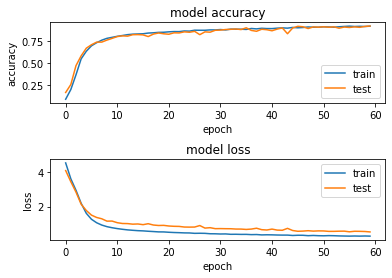

Final Test Accuracy: 0.9315987229347229


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.96      1.00      0.98       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os02g0655200         334              101       False
1  Os01g0741900         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.507
1,2,0.775
2,3,0.823
3,4,0.877
4,5,0.875
5,6,0.908
6,7,0.879
7,8,0.887
8,9,0.932
9,10,0.883
